## Projection simulations check:
- check dVdt -> corresponds approximately to Hugonnet et al. by comparing W5E5 vs W5E5_spinup
    - e.g.: https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~pschmitt/dynamic_prepro/analysis_dyn_spn.ipynb?flush_cache=true
    - and: https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~lschuster/error_analysis/working_glacier_gdirs_comparison.ipynb
- 


In [24]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
cfg.initialize()
import seaborn as sns
sns.set_context('talk')

2023-05-03 15:44:00: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-03 15:44:00: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-03 15:44:00: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [25]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']

In [26]:
working_all = True
if working_all:
    pd_working_all = pd.read_csv('all_common_working_rgi_ids.csv', index_col='rgiid')
    all_running_rgis = pd_working_all.index
else:
    all_running_rgis_d = {}
    for hist in ['w5e5_gcm_merged', 'gcm_from_2000']:
        #for bc in ['_bc_2000_2019']:
        pd_working = pd.read_csv(f'working_rgis_for_oggm_v16_CMIP6{bc}_{hist}.csv', index_col='rgiid', low_memory=False)
        all_running_rgis_d[hist] = pd_working['all_running_rgis'].dropna().index.values
        print(len(all_running_rgis_d[hist]))
    all_running_rgis = list(set(all_running_rgis_d['w5e5_gcm_merged']).intersection(all_running_rgis_d['gcm_from_2000']))
    pd_working_all = pd_working.loc[all_running_rgis][['area','all_running_rgis', 'rgi_reg']]
    pd_working_all = pd_working_all.dropna()

In [27]:
all_running_rgis = pd_working_all.index.values
pd_geodetic_running = pd_geodetic.loc[all_running_rgis]

0.9615842739844024

In [28]:


period = '2000-01-01_2020-01-01'

#dfz = pd.read_csv(utils.get_demo_file('zemp_ref_2006_2016.csv'), index_col=0)
#dfh['dmdt_zemp'] = dfz.SMB.values * 1000
#dfh['dmdt_zemp_err'] = dfz.SMB_err.values * 1000
dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'), index_col=0)
dfh = dfh.loc[dfh.period == period]


dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]



In [29]:

# get those geodetic estimates of the common running glaciers and that do the mean! 
dmdtda_working_glaciers_geods = {}
dmdt_working_glaciers_geods = {}
for reg in np.arange(1,20,1):
    pd_geodetic_running_reg = pd_geodetic_running[pd_geodetic_running.reg == reg]

    dmdtda_working_glaciers_geod = np.average(pd_geodetic_running_reg.dmdtda*1e3, weights=pd_geodetic_running_reg.area)
    dmdt_working_glaciers_geod = (pd_geodetic_running_reg.dmdtda*1e3*pd_geodetic_running_reg.area).sum()*1e-12
    rgi_reg  = '{:02d}'.format(reg)
    dmdtda_working_glaciers_geods[rgi_reg] = dmdtda_working_glaciers_geod
    dmdt_working_glaciers_geods[rgi_reg] = dmdt_working_glaciers_geod
pd_working_glaciers_geod =pd.DataFrame([dmdt_working_glaciers_geods,dmdtda_working_glaciers_geods],
                                       index=['dmdt_geodetic_only_running_glaciers', 'dmdtda_geodetic_only_running_glaciers']).astype(float)





In [30]:
# ok the summary statistcs are all the same except for glacier_statistics....
run = False
border = '160'
if run:
    path = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands'
    for rgi_reg in np.arange(1, 20):
        rgi_reg_int = rgi_reg.copy()

        rgi_reg = '{:02d}'.format(rgi_reg)
        all_running_rgis_reg = pd_working_all.loc[pd_working_all.rgi_reg==rgi_reg_int]['all_running_rgis'].dropna().index

        ds_l = []
        df_l = []
        dfs_l = []
        for opt in ['W5E5', 'W5E5_spinup']:

            fd = f'{path}/{opt}/RGI62/b_{border}/L5/summary/'


            df_l.append(pd.read_csv(fd + f'fixed_geometry_mass_balance_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False))
            dfs_l.append(pd.read_csv(fd + f'glacier_statistics_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False))
            with xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc') as ds:
                ds = ds[['volume', 'area']].sum(dim='rgi_id')
                ds_l.append(ds)
        np.testing.assert_allclose(df_l[0], df_l[1])
        np.testing.assert_allclose(ds_l[0].volume, ds_l[1].volume)
        np.testing.assert_allclose(ds_l[0].area, ds_l[1].area)

In [31]:
run = False
border = '160'
if run:
    for opt in ['W5E5', 'W5E5_spinup']:

        path = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands'
        fd = f'{path}/{opt}/RGI62/b_{border}/L5/summary/'

        for rgi_reg in np.arange(1, 20):
            rgi_reg_int = rgi_reg.copy()
            all_running_rgis_reg = pd_working_all.loc[pd_working_all.rgi_reg==rgi_reg_int]['all_running_rgis'].dropna().index
            rgi_reg = '{:02d}'.format(rgi_reg)

            
            try:
                df = pd.read_csv(fd + f'fixed_geometry_mass_balance_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False)
                dfs = pd.read_csv(fd + f'glacier_statistics_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False)
            except FileNotFoundError:
                #print('Not here:',rgi_reg)
                continue

            df = df.dropna(axis=0, how='all')
            # just choose those glaciers that work for all prepro gdirs types!
            df = df[all_running_rgis_reg]
            # check if there are no np.NaNs (otherwise sth. is wrong with all_running_rgis_reg)
            assert ~np.any(df.isna())
            #df = df.dropna(axis=1, how='all')
            #         odf = pd.DataFrame(df.loc[2006:2016].mean(), columns=['SMB'])
            #         odf['AREA'] = dfs.rgi_area_km2

            #         dfh.loc[rgi_reg, 'AREA_OGGM'] = odf['AREA'].sum()
            #         dfh.loc[rgi_reg, 'SMB_OGGM'] = np.average(odf['SMB'], weights=odf['AREA']) / 1000

            odf = pd.DataFrame(df.loc[2000:].mean(), columns=['SMB'])
            odf['AREA'] = dfs.rgi_area_km2
            dfh.loc[rgi_reg, f'dmdt_OGGM_{opt}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) * cfg.PARAMS['ice_density'] * 1e-12 / 20
            dfh.loc[rgi_reg, f'dmdtda_OGGM_{opt}'] = np.average(odf['SMB'], weights=odf['AREA'])

            if opt == 'W5E5':
                stat = f'historical_run_output_extended_{rgi_reg}.nc'
            else:
                stat = f'spinup_historical_run_output_{rgi_reg}.nc'
            with xr.open_dataset(fd +stat) as ds:
                ds = ds.sel(rgi_id=all_running_rgis_reg)
                ds = ds[['volume', 'area']].sum(dim='rgi_id')
            vol_ts = ds.volume.to_series()
            area_ts = ds.area.to_series()
            # dmdt is in kg per year *10e-12
            dfh.loc[rgi_reg, f'dmdt_dyna_OGGM_{opt}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) * cfg.PARAMS['ice_density'] * 1e-12 / 20
            dfh.loc[rgi_reg, f'dmdtda_dyna_OGGM_{opt}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) / area_ts.loc[2000] * cfg.PARAMS['ice_density'] / 20 
            dfh.loc[rgi_reg, f'area_OGGM_2000_{opt}'] = area_ts.loc[2000]       
            dfh.loc[rgi_reg, f'vol_OGGM_2000_{opt}'] = vol_ts.loc[2000]  
            
            with xr.open_mfdataset(f'/home/www/lschuster/runs_oggm_v16/output/RGI{rgi_reg}/run_hydro_w5e5_gcm_merged_endyr2100_CMIP6_BCC-CSM2-MR_ssp245_bc_2000_2019_rgi{rgi_reg}*.nc') as dproj:
                dproj = dproj.sel(rgi_id=all_running_rgis_reg)
                dproj = dproj[['volume', 'area']].sum(dim='rgi_id')
            vol_ts = dproj.volume.to_series()
            area_ts = dproj.area.to_series()
            dproj.close()
            
            dfh.loc[rgi_reg, f'dmdtda_dyna_OGGM_proj_{opt}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) / area_ts.loc[2000] * cfg.PARAMS['ice_density'] / 20 
            dfh.loc[rgi_reg, f'area_OGGM_2000_proj_{opt}'] = area_ts.loc[2000]       
            dfh.loc[rgi_reg, f'vol_OGGM_2000_proj_{opt}'] = vol_ts.loc[2000]  
            
            
    dfhh = pd.concat([dfh,pd_working_glaciers_geod.T], axis=1)
    dfhh.to_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs.csv')
else:
    # new with (partly) preprocessed gdirs
    dfh = pd.read_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs.csv', index_col=[0])
    # old with wrong preprocessed gdirs: dfh = pd.read_csv(f'dmdtda_dmdt_for_prepro_level_5_gdirs.csv', index_col=[0])
    dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]

In [73]:
xr.open_dataset(fd +stat)['is_fixed_geometry_spinup']

<xarray.DataArray 'is_fixed_geometry_spinup' (time: 42, rgi_id: 2752)>
[115584 values with dtype=float32]
Coordinates:
  * time            (time) float64 1.979e+03 1.98e+03 ... 2.019e+03 2.02e+03
  * rgi_id          (rgi_id) object 'RGI60-19.00001' ... 'RGI60-19.02752'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Attributes:
    description:  Part of the series which are spinup
    unit:         -

In [33]:
dfh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_OGGM_W5E5  dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  \
01       -682.867030            -597.772765         7.031038e+10   
02       -520.062346            -459.171867         1.504163e+10   
03       -290.846673            -313.887098         1.050887e+11   
04       -648.224633            -616.083369         4.091611e+10   
05       -395.943637            -365.734434         8.969990e+10   
06       -846.380030            -785.782785         1.105934e+10   
07       -303.312236            -277.946870         3.397060e+10   
08       -565.171709            -537.874403         2.948294e+09   
09       -202.111130            -216.501646         5.156761e+10   
10       -520.976144            -498.682909         2.321455e+09   
11       -804.911322            -735.565310         2.091841e+09   
12       -508.004299            -448.928361         1.149040e+09   
13       -195.669760            -181.528323         4.921490e+10   
14       -135.945961            -141.278547         3.359802e+10   
15       -468.178425            -435.259180         1.472464e+10   
16       -399.241599            -357.722182         2.340964e+09   
17       -450.563247            -437.735782         1.970439e+10   
18       -554.401058            -464.552979         1.173936e+09   
19       -157.501651            -287.251754         1.355254e+11   

    vol_OGGM_2000_W5E5  dmdtda_dyna_OGGM_proj_W5E5  ...  \
01        1.407449e+13                 -605.323377  ...   
02        1.079413e+12                 -468.670707  ...   
03        2.832242e+13                 -317.177610  ...   
04        8.672269e+12                 -609.177732  ...   
05        1.576957e+13                 -372.083244  ...   
06        3.785219e+12                 -752.360573  ...   
07        7.565824e+12                 -274.618549  ...   
08        3.061147e+11                 -519.610319  ...   
09        1.468823e+13                 -215.229335  ...   
10        1.407462e+11                 -491.310310  ...   
11        1.328812e+11                 -755.383444  ...   
12        6.012630e+10                 -468.323522  ...   
13        3.310739e+12                 -188.710806  ...   
14        2.893355e+12                 -146.201431  ...   
15        9.025321e+11                 -460.624337  ...   
16        9.756558e+10                 -332.580099  ...   
17        2.438643e+12                 -422.366381  ...   
18        6.891251e+10                 -466.099648  ...   
19        4.590611e+13                 -247.144597  ...   

    vol_OGGM_2000_proj_W5E5  dmdtda_OGGM_W5E5_spinup  \
01             1.419259e+13              -682.867030   
02             1.015489e+12              -52

In [91]:
pd_geodetic

period       area    dmdtda  err_dmdtda  reg  \
rgiid                                                                         
RGI60-01.00001  2000-01-01_2020-01-01   360000.0 -0.012800    0.217600    1   
RGI60-01.00002  2000-01-01_2020-01-01   558000.0 -0.229000    0.146000    1   
RGI60-01.00003  2000-01-01_2020-01-01  1685000.0 -0.797900    0.166900    1   
RGI60-01.00004  2000-01-01_2020-01-01  3681000.0 -0.407500    0.141600    1   
RGI60-01.00005  2000-01-01_2020-01-01  2573000.0  0.039000    0.142000    1   
...                               ...        ...       ...         ...  ...   
RGI60-19.02748  2000-01-01_2020-01-01    42000.0 -0.136311    0.295265   19   
RGI60-19.02749  2000-01-01_2020-01-01   567000.0 -0.826800    0.448800   19   
RGI60-19.02750  2000-01-01_2020-01-01  4118000.0 -0.411700    0.611200   19   
RGI60-19.02751  2000-01-01_2020-01-01    11000.0 -0.136311    0.295265   19   
RGI60-19.02752  2000-01-01_2020-01-01   528000.0 -0.038600    0.289700   19   

                is_cor  
rgiid                   
RGI60-01.00001   False  
RGI60-01.00002   False  
RGI60-01.00003   False  
RGI60-01.00004   False  
RGI60-01.00005   False  
...                ...  
RGI60-19.02748    True  
RGI60-19.02749   False  
RGI60-19.02750   False  
RGI60-19.02751    True  
RGI60-19.02752   False  

[215547 rows x 6 columns]

In [56]:
pd_geodetic_running.groupby('reg').sum()

area        dmdtda    err_dmdtda  is_cor
reg                                                  
1    7.031040e+10 -11392.595383   7004.929359     330
2    1.452140e+10  -6408.731606   5252.528080    1488
3    1.050886e+11  -1710.270166    671.791517      40
4    4.088390e+10  -3144.966749   1490.350682      39
5    8.969407e+10  -5459.371230   3899.777183     177
6    1.105935e+10   -191.571300    105.677100       0
7    3.418651e+10   -483.117626    238.644855       3
8    2.948299e+09  -1389.970401    870.950164      48
9    5.156762e+10   -313.633200    143.908800       0
10   2.321469e+09  -2056.945832   1756.963639     176
11   2.091777e+09  -2339.898779   1570.482648     570
12   1.326768e+09   -714.130208    452.447654     311
13   4.921626e+10 -11252.980441  13896.101259     989
14   3.355488e+10  -3111.328675   7184.219254    1072
15   1.472509e+10  -5715.962898   3613.493733     357
16   2.340879e+09   -952.107914    829.167329     222
17   1.970445e+10  -3490.407444   5002.623670    1467
18   1.161749e+09   -705.293923   1245.119869     550
19   1.322927e+11   -383.345191    660.002154     258

In [53]:
dfh[['area_OGGM_2000_W5E5', 'area_OGGM_2000_W5E5_spinup', 'area_OGGM_2000_proj_W5E5_spinup']]

area_OGGM_2000_W5E5  area_OGGM_2000_W5E5_spinup  \
01         7.031038e+10                7.153690e+10   
02         1.504163e+10                1.557374e+10   
03         1.050887e+11                1.054534e+11   
04         4.091611e+10                4.137931e+10   
05         8.969990e+10                9.078941e+10   
06         1.105934e+10                1.107997e+10   
07         3.397060e+10                3.411341e+10   
08         2.948294e+09                3.119956e+09   
09         5.156761e+10                5.175823e+10   
10         2.321455e+09                2.632843e+09   
11         2.091841e+09                2.147618e+09   
12         1.149040e+09                1.162906e+09   
13         4.921490e+10                5.070877e+10   
14         3.359802e+10                3.452558e+10   
15         1.472464e+10                1.492772e+10   
16         2.340964e+09                2.458291e+09   
17         1.970439e+10                2.004916e+10   
18         1.173936e+09                1.179882e+09   
19         1.355254e+11                1.355425e+11   

    area_OGGM_2000_proj_W5E5_spinup  
01                     7.153719e+10  
02                     1.557368e+10  
03                     1.054534e+11  
04                     4.137927e+10  
05                     9.078936e+10  
06                     1.107997e+10  
07                     3.411341e+10  
08                     3.119956e+09  
09                     5.175822e+10  
10                     2.632842e+09  
11                     2.147616e+09  
12                     1.162905e+09  
13                     5.070921e+10  
14                     3.452543e+10  
15                     1.492774e+10  
16                     2.458289e+09  
17                     2.004910e+10  
18                     1.179882e+09  
19                     1.355425e+11

In [50]:
dfh[['vol_OGGM_2000_W5E5', 'vol_OGGM_2000_W5E5_spinup', 'vol_OGGM_2000_proj_W5E5_spinup']]

vol_OGGM_2000_W5E5  vol_OGGM_2000_W5E5_spinup  \
01        1.407449e+13               1.419516e+13   
02        1.079413e+12               1.015611e+12   
03        2.832242e+13               2.750947e+13   
04        8.672269e+12               8.730939e+12   
05        1.576957e+13               1.547965e+13   
06        3.785219e+12               3.789366e+12   
07        7.565824e+12               7.544915e+12   
08        3.061147e+11               3.081740e+11   
09        1.468823e+13               1.396682e+13   
10        1.407462e+11               1.339931e+11   
11        1.328812e+11               1.275704e+11   
12        6.012630e+10               6.127591e+10   
13        3.310739e+12               3.307080e+12   
14        2.893355e+12               2.880364e+12   
15        9.025321e+11               8.861898e+11   
16        9.756558e+10               9.302077e+10   
17        2.438643e+12               2.336059e+12   
18        6.891251e+10               6.872100e+10   
19        4.590611e+13               4.533179e+13   

    vol_OGGM_2000_proj_W5E5_spinup  
01                    1.419259e+13  
02                    1.015489e+12  
03                    2.750947e+13  
04                    8.730872e+12  
05                    1.548381e+13  
06                    3.789364e+12  
07                    7.538178e+12  
08                    3.081384e+11  
09                    1.396005e+13  
10                    1.335681e+11  
11                    1.275209e+11  
12                    6.126510e+10  
13                    3.306260e+12  
14                    2.880236e+12  
15                    8.862605e+11  
16                    9.301621e+10  
17                    2.336176e+12  
18                    6.872105e+10  
19                    4.532864e+13

In [64]:
dfh.index.values

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19'], dtype=object)

/tmp/ipykernel_2725909/2017426215.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


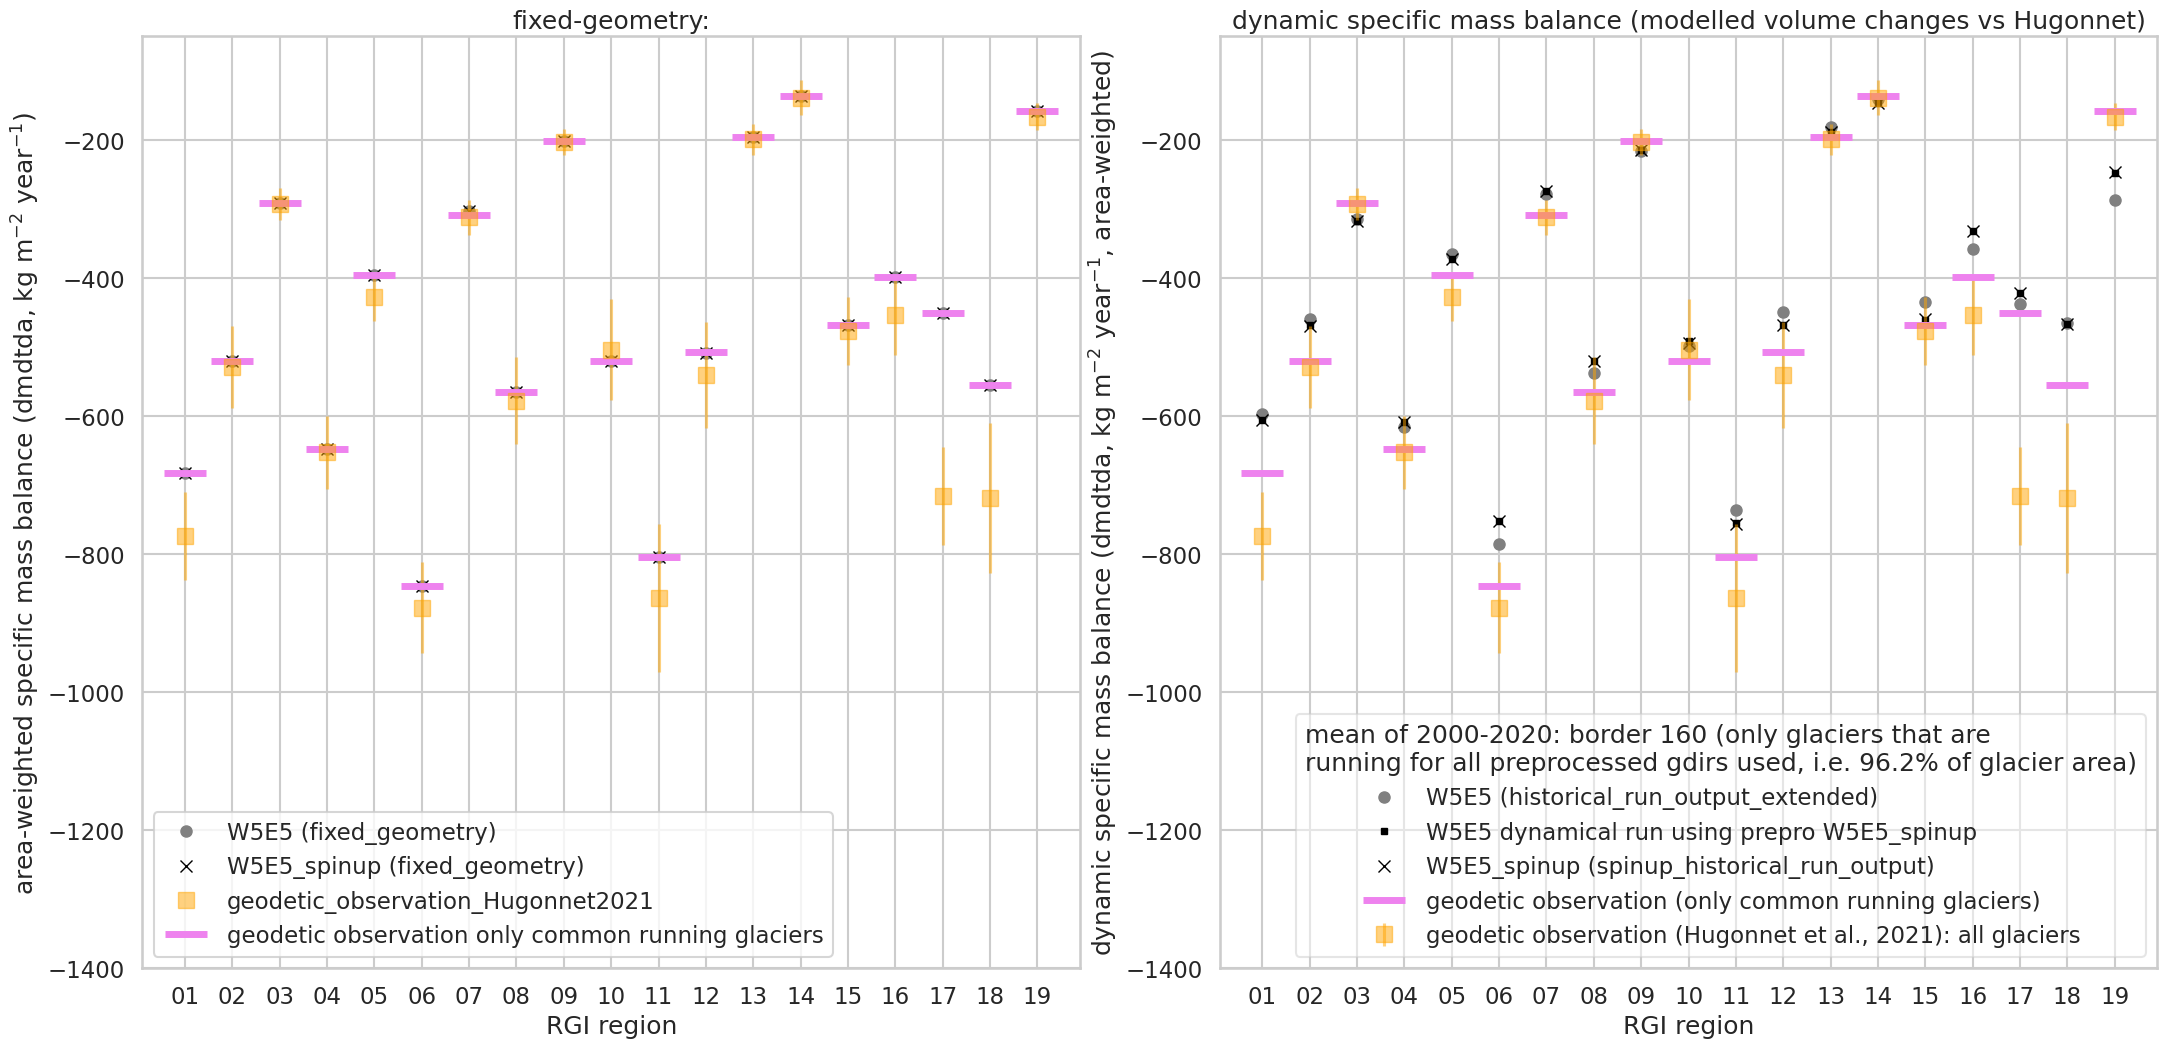

In [70]:
plt.figure(figsize=(26,26))
n=17

ax = plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)

#plt.figure(figsize=(20,10))
#f, ax = plt.subplots()
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
for opt in ['W5E5', 'W5E5_spinup']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            dfh.plot(ax=ax, y=f'dmdtda_OGGM_{opt}', marker=markers[opt],
                             linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                             label=f'{opt} (fixed_geometry)')

        else:
            dfh.plot(ax=ax, y=f'dmdtda_OGGM_{opt}', marker=markers[opt],
                 linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                 label=f'{opt} (fixed_geometry)')
            
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic_observation_Hugonnet2021', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'area-weighted specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.title(r'fixed-geometry:')
plt.xlabel('RGI region')
plt.xticks(np.arange(0,19,1), dfh.index.values)
#f = ax.get_legend()
#f.remove()
plt.ylim([-1400,-50])




ax = plt.subplot2grid((n, n), (0, 9), colspan=8, rowspan=8)

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
for opt in ['W5E5', 'W5E5_spinup']:
        if opt=='W5E5_spinup':
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
                             linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
                             label=f'W5E5 dynamical run using prepro {opt}')
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{opt}', marker=markers[opt],
                             linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                             label=f'{opt} (spinup_historical_run_output)')

        else:
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{opt}', marker=markers[opt],
                 linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                 label=f'{opt} (historical_run_output_extended)')

dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic observation (Hugonnet et al., 2021): all glaciers', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers', marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'dynamic specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$, area-weighted)')
plt.xlabel('RGI region')
plt.title('dynamic specific mass balance (modelled volume changes vs Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, loc='lower right', 
          title=f'mean of 2000-2020: border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')

plt.tight_layout()


In [71]:
ds

<xarray.Dataset>
Dimensions:         (time: 42)
Coordinates:
  * time            (time) float64 1.979e+03 1.98e+03 ... 2.019e+03 2.02e+03
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    volume          (time) float32 4.567e+13 4.567e+13 ... 4.459e+13 4.457e+13
    area            (time) float32 1.327e+11 1.337e+11 ... 1.344e+11 1.344e+11

In [ ]:
border = 160
qc = 'qc3'

plt.figure(figsize=(26,26))
n=17
dfh = pd.read_csv('dmdtda_dmdt_for_prepro_level_5_gdirs_new.csv', index_col=[0])
dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]
dfh['dmdt_geodetic_only_running_glaciers'] = pd_working_glaciers_geod.T['dmdt_geodetic_only_running_glaciers'].values
dfh['dmdtda_geodetic_only_running_glaciers'] = pd_working_glaciers_geod.T['dmdtda_geodetic_only_running_glaciers'].values
###
###
ax = plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)

#plt.figure(figsize=(20,10))
ax = plt.gca()
#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdt_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic_observation_Hugonnet2021', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'regional total mass change (dmdt, Gt year$^{-1}$)')
plt.xlabel('RGI region')
plt.xticks(np.arange(0,18,1), dfh.index.values)
f = ax.get_legend()
f.remove()
###
ax = plt.subplot2grid((n, n), (9, 0), colspan=8, rowspan=8)
#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12, linewidth=4,
                   label = 'geodetic observation (Hugonnet et al., 2021)', color = 'orange', alpha = 0.7)
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdtda_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
#t=ax.get_legend_handles_labels()
#t[0] = [t[0][-1]].append(t[:-1])

dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'area-weighted specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.xlabel('RGI region')
plt.xticks(np.arange(0, 18, 1), dfh.index.values)
f = ax.get_legend()
f.remove()
plt.title('area-weighted mean MB from "fixed_geometry_mass_balance"')


##
#plt.figure(figsize=(20,10))
ax = plt.subplot2grid((n, n), (9, 9), colspan=8, rowspan=8)

#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
bu=[]
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic observation (Hugonnet et al., 2021)', color = 'orange', alpha = 0.7)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'dynamic specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.xlabel('RGI region')
plt.title('using volume changes from "historical_run_output_extended"')
plt.xticks(np.arange(0,18,1), dfh.index.values);
plt.ylim([-1600,-50])
ax.legend(framealpha=0.5, ncol=1, loc=3, bbox_to_anchor=(0.17,1.3),
          title=f'mean of 2000-2020: {qc}, border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {len(all_running_rgis)*100/len(pd_working):0.1f}%)')

#ax.legend()
######
#plt.tight_layout()

ax = plt.subplot2grid((n, n), (1, 9), rowspan=6, colspan=1)
rgi_index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in np.arange(1,20)]
dfh.loc['all', 'dmdt'] = dfh.loc[rgi_index].dmdt.sum()
dfh.loc['all', 'err_dmdt'] = dfh.loc[rgi_index].err_dmdt.sum()

dfh.loc['all', 'period'] = dfh.period[0]
for exp in ['elev_bands', 'centerlines']:
        for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  
            for pcp, clim in zip(pcps, clims):
                try:
                    dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}'
                    dfh.loc['all', f'dmdt_OGGM_{opt}'] = dfh.loc[rgi_index, f'dmdt_OGGM_{opt}'].sum()
                except:
                    pass
###
#plt.figure(figsize=(3,6))
ax = plt.gca()
#ax.errorbar(['geodetic observation (Hugonnet et al., 2021)'],
#            df_dmdt_all.dmdt, yerr=df_dmdt_all.err_dmdt,
#            marker='s', color='orange', alpha=0.8)

df_dmdt_all = dfh.loc['all_without_19'][1:].dropna()
plt.axhline(df_dmdt_all.dmdt, color='orange', alpha = 0.3)
plt.axhspan(df_dmdt_all.dmdt-df_dmdt_all.err_dmdt,
            df_dmdt_all.dmdt + df_dmdt_all.err_dmdt, alpha = 0.1, color='orange')

#dmdtda_working_glaciers_geods['all_without_19'] = np.average(pd_geodetic_running.dmdtda, weights=pd_geodetic_running.area)*1e3
plt.axhline((pd_geodetic_running.dmdtda*1e3*pd_geodetic_running.area).sum()*1e-12,
            color='violet', alpha=0.5, linewidth=5)
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                ax.errorbar(x=[f'{exp}_{clim}_{pcp}_{match}'], # [0]
                            y=df_dmdt_all[f'dmdt_OGGM_{dict_key_short}'],
                            marker=markers[clim],
                            linestyle='none', markersize=8, color=colors[match], alpha=alphas[exp],
                            label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
plt.ylabel(r'world-wide total mass-change (dmdt, Gt year$^{-1}$)')
plt.xticks(ticks=[3.5],labels=['all without RGI 19'])
plt.xlim([-1,9.5])
plt.grid(axis='x')

plt.savefig(f'dmdtda_dmdt_for_prepro_level_gdirs_{qc}_b{border}.png', bbox_inches='tight', pad_inches=0)
plt.savefig(f'dmdtda_dmdt_for_prepro_level_gdirs_{qc}_b{border}.pdf', bbox_inches='tight', pad_inches=0.2)

In [84]:
dfh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_OGGM_W5E5  dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  \
01       -682.867030            -678.438420         8.671674e+10   
02       -520.062346            -458.972311         1.504937e+10   
03       -290.846673            -313.764167         1.051061e+11   
04       -648.224633            -616.008782         4.091842e+10   
05       -395.943637            -365.575862         8.972035e+10   
06       -846.380030            -785.780554         1.105953e+10   
07       -303.312236            -277.919769         3.397128e+10   
08       -565.171709            -537.845993         2.948529e+09   
09       -202.111130            -216.460018         5.157186e+10   
10       -520.976144            -497.623844         2.323438e+09   
11       -804.911322            -735.500422         2.091911e+09   
12       -508.004299            -448.327761         1.151103e+09   
13       -195.669760            -181.435905         4.924147e+10   
14       -135.945961            -141.183575         3.360750e+10   
15       -468.178425            -434.848781         1.472894e+10   
16       -399.241599            -357.715037         2.341109e+09   
17       -450.563247            -682.994657         2.940483e+10   
18       -554.401058            -464.557271         1.173934e+09   
19       -157.501651            -289.806633         1.358448e+11   

    vol_OGGM_2000_W5E5  dmdtda_OGGM_W5E5_spinup  dmdtda_dyna_OGGM_W5E5_spinup  \
01        1.946116e+13              -682.867030                   -678.438420   
02        1.079486e+12              -520.062346                   -458.972311   
03        2.832337e+13              -290.846673                   -313.764167   
04        8.672361e+12              -648.224633                   -616.008782   
05        1.577052e+13              -395.943637                   -365.575862   
06        3.785239e+12              -846.380030                   -785.780554   
07        7.565840e+12              -303.312236                   -277.919769   
08        3.061212e+11              -565.171709                   -537.845993   
09        1.468843e+13              -202.111130                   -216.460018   
10        1.407830e+11              -520.976144                   -497.623844   
11        1.328835e+11              -804.911322                   -735.500422   
12        6.017304e+10              -508.004299                   -448.327761   
13        3.311656e+12              -195.669760                   -181.435905   
14        2.893592e+12              -135.945961                   -141.183575   
15        9.026204e+11              -468.178425                   -434.848781   
16        9.756864e+10              -399.

In [74]:
    dfhh = pd.concat([dfh,pd_working_glaciers_geod.T], axis=1)
    dfhh.to_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs.csv')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [72]:
dfhh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_OGGM_W5E5  dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  \
01       -682.867030            -678.438420         8.671674e+10   
02       -520.062346            -458.972311         1.504937e+10   
03       -290.846673            -313.764167         1.051061e+11   
04       -648.224633            -616.008782         4.091842e+10   
05       -395.943637            -365.575862         8.972035e+10   
06       -846.380030            -785.780554         1.105953e+10   
07       -303.312236            -277.919769         3.397128e+10   
08       -565.171709            -537.845993         2.948529e+09   
09       -202.111130            -216.460018         5.157186e+10   
10       -520.976144            -497.623844         2.323438e+09   
11       -804.911322            -735.500422         2.091911e+09   
12       -508.004299            -448.327761         1.151103e+09   
13       -195.669760            -181.435905         4.924147e+10   
14       -135.945961            -141.183575         3.360750e+10   
15       -468.178425            -434.848781         1.472894e+10   
16       -399.241599            -357.715037         2.341109e+09   
17       -450.563247            -682.994657         2.940483e+10   
18       -554.401058            -464.557271         1.173934e+09   
19       -157.501651            -289.806633         1.358448e+11   

    vol_OGGM_2000_W5E5  dmdtda_OGGM_W5E5_spinup  dmdtda_dyna_OGGM_W5E5_spinup  \
01        1.946116e+13              -682.867030                   -678.438420   
02        1.079486e+12              -520.062346                   -458.972311   
03        2.832337e+13              -290.846673                   -313.764167   
04        8.672361e+12              -648.224633                   -616.008782   
05        1.577052e+13              -395.943637                   -365.575862   
06        3.785239e+12              -846.380030                   -785.780554   
07        7.565840e+12              -303.312236                   -277.919769   
08        3.061212e+11              -565.171709                   -537.845993   
09        1.468843e+13              -202.111130                   -216.460018   
10        1.407830e+11              -520.976144                   -497.623844   
11        1.328835e+11              -804.911322                   -735.500422   
12        6.017304e+10              -508.004299                   -448.327761   
13        3.311656e+12              -195.669760                   -181.435905   
14        2.893592e+12              -135.945961                   -141.183575   
15        9.026204e+11              -468.178425                   -434.848781   
16        9.756864e+10              -399.

In [62]:
dfhh

Empty DataFrame
Columns: []
Index: [01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [28]:
xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc').volume

<xarray.DataArray 'volume' (time: 119, rgi_id: 2752)>
[327488 values with dtype=float32]
Coordinates:
  * time            (time) float64 1.902e+03 1.903e+03 ... 2.019e+03 2.02e+03
  * rgi_id          (rgi_id) object 'RGI60-19.00001' ... 'RGI60-19.02752'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Attributes:
    description:  Total glacier volume (extended with MB data)
    unit:         m 3

In [31]:
fd_w5e5_spinup = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5_spinup/RGI62/b_160/L5/summary/'
fd = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5/RGI62/b_160/L5/summary/'

np.testing.assert_allclose(xr.open_dataset(fd_w5e5_spinup + f'historical_run_output_extended_{rgi_reg}.nc').volume,
                           xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc').volume)

In [24]:
dfh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  vol_OGGM_2000_W5E5  \
01            -678.438420         8.671674e+10        1.946116e+13   
02            -458.972311         1.504937e+10        1.079486e+12   
03            -313.764167         1.051061e+11        2.832337e+13   
04            -616.008782         4.091842e+10        8.672361e+12   
05            -365.575862         8.972035e+10        1.577052e+13   
06            -785.780554         1.105953e+10        3.785239e+12   
07            -277.919769         3.397128e+10        7.565840e+12   
08            -537.845993         2.948529e+09        3.061212e+11   
09            -216.460018         5.157186e+10        1.468843e+13   
10            -497.623844         2.323438e+09        1.407830e+11   
11            -735.500422         2.091911e+09        1.328835e+11   
12            -448.327761         1.151103e+09        6.017304e+10   
13            -181.435905         4.924147e+10        3.311656e+12   
14            -141.183575         3.360750e+10        2.893592e+12   
15            -434.848781         1.472894e+10        9.026204e+11   
16            -357.715037         2.341109e+09        9.756864e+10   
17            -682.994657         2.940483e+10        5.339397e+12   
18            -464.557271         1.173934e+09        6.891259e+10   
19            -289.806633         1.358448e+11        4.596159e+13   

    dmdtda_dyna_OGGM_W5E5_spinup  area_OGGM_2000_W5E5_spinup  \
01                   -678.438420                8.671674e+10   
02                   -458.972311                1.504937e+10   
03                   -313.764167                1.051061e+11   
04                   -616.008782                4.091842e+10   
05                   -365.575862                8.972035e+10   
06                   -785.780554                1.105953e+10   
07                   -277.919769                3.397128e+10   
08                   -537.845993                2.948529e+09   
09                   -216.460018                5.157186e+10   
10                   -497.623844                2.323438e+09   
11                   -735.500422                2.091911e+09   
12                   -448.327761                1.151103e+09   
13                   -181.435905                4.924147e+10   
14                   -141.183575                3.360750e+10   
15                   -434.848781                1.472894e+10   
16                   -357.715037                2.341109e+09   
17                   -682.994657                2.940483e+10   
18                   -464.557271                1.173934e+09   
19                   -289.806633                1.358448e+11   

    vol_OGGM_200